# Paralelni algoritmi - drugi projekat

- Projekat se radi individualno ili u paru

- Rok za predaju projekata je ponedeljak 14.12.2020. Biće potrebno da se studenti koji planiraju da urade i odbrane projekat prijave, do datuma i procedurom koji će naknadno biti objavljeni.

- Predaja projekata je putem emaila, programski kod bi trebalo da
bude prikacen uz sam email. Link ka Collab-u je opcion. Ukoliko dva
studenta rade u paru, dovoljno je da jedan od njih preda, pri cemu
drugog stavi u cc. E-mail treba da sadrzi sve podatke (ime, prezime,
broj indeksa) za oba studenta.


1. **Pristup tekstu sa Wikipedije putem MapReduce programa (6 bodova)**  
Napisati program koji kroz map-reduce paradigmu (upotrebom funkcije *map* iz Python standardne biblioteke i funkcije *reduce* iz paketa *functools*):
  - Za zadatu listu ključnih reči vrši pretragu Wiki stranica i dohvata zadati broj rezultata (naslova stranica)
    Za pristup wiki stranicama se može koristiti python biblioteku [*wikipedia*](https://pypi.org/project/wikipedia/):
```python
import wikipedia
wikipedia.set_lang("sr")
```
```python
def get_pages(query, results=50):
  '''Dohvata naslove zahtevanog broja stranica koje se pojavaljuju kao 
      rezultati pretrage za zadatu kljucnu rec'''
      pages = wikipedia.search(query, results=results)
      return pages
```
  - Paralelizovati rešenje iz prethodne tačke upotrebom funkcija `Pool.map` iz paketa `multiprocessing`
  - Wikipedia API ponekad vrati nevalidne naslove stranica, pa je rezultate neophodno sanitizovati. Napisati map/reduce rešenje koje sanitizuje rezultate iz prethodne tačke. Sanitizacija se može izvesti pokušajem da dohvatanja stranice na osnovu nasova (`wikipedia.page(title)`) i hvatanjem izuzetaka.
  - Napisati map/reduce rešenje koje dohvata sažetke stranica (`page.summary`) iz sanitizovane liste formirane u prethodnoj tački.
  - Wikipedia API ponekad meša stranice na ćiriličnom i latiničnom pismu. Unifikovati tekstive dobijene u prethodnoj tački prevođenjem reči na isto pismo (ćirilično ili latinično)
  ```python
import transliterate
transliterate.translit(word, 'sr')
```
 - Odabrati nekoliko ključnih reči po slobodnom izboru i pokazati da program radi dohvatanjem po dva rezultata za svaku kljunu reč.

2. **Brojanje reci u tesktu i bag-of-words reprezentacija putem MapReduce programa (8 bodova)**  
U ovom zadatku ćemo stranice predstaviti kao *bag-of-words* vektore. *Bag-of-words* reprezentacija se dobija tako što za *sve** reči koje se pojavljuju u svim tekstovima izbrojimo koliko puta se pojavljuju u svakom tekstu. Tekst potom predstvaljamo kao vektor ovih brojeva.   
Na primer, posmatrajmo dva teksta:
``` 
Pera voli da gleda filmove. Mika takođe voli filmove.
``` 
```
Mika voli da gleda i fudbalske utakmice.
```
Reči koje se pojavljuju su:
```
Pera, voli, da, gleda, filmove, Mika, takođe, i, fudbalske, utakmice
``` 
  *Bag-of-words* reprezentacija tekstova je:
```
1, 2, 1, 1, 2, 1, 1, 0, 0, 0
```
odnosno:
```
0, 1, 1, 1, 0, 1, 0, 1, 1, 1
```
U praksi se reči koje se previše često ili previše retko pojavljuju uglavnom odbacuju. 
  - Napisati map/reduce program koji datu listu tesktiva pretvara u *Bag-of-words* reprezentaciju. Pre brojanja reči potrebno je sve reči prevesti u mala ili velika slova (po vašem izboru), te izbaciti interpunkcijske znake i specijalne karaktere (u najmanju ruku sledeći skup `\n, \t, =, -, (, ), _`). Odbaciti reči koje se pojavljuju veoma često u većini tekstovima (nalaze se u 10% najčešćih reči u bar 90% tekstova), ili se pojavljuju u manje od 1% tekstova. Ovu obradu izvesti kroz posebne map/reduce korake.
  - Ručno uneti nekoliko tekstova po slobodnom izboru i pokazati da program radi.

3. **K-means klastersanje putem MapReduce programa (5 bodova)**   
Napisati map/reduce program koji vrši k-means klasterisanje liste vektora.
Nasumično generisati podatke iz nekoliko normalnih raspodela u dve dimenzije i pokazati da algoritam radi (videti vežbe za primer). 

4. **Primena rešenja  (6 bodova)**  
Povezati kod iz zadataka 1-3 kojim se Wiki na srpskom jeziku pretražuje za sledeći skup ključnih reči `['Beograd', 'Prvi svetski rat', 'Protein', 'Mikroprocesor', 'Stefan Nemanja', 'Košarka']`, za svaku dohvata po 50 rezultata, stranice prevode u *bag-of-words* reprezentaciju, i vrši njihovo klasterisanje. 
U kojom meri klasteri odgovaraju temama prema kojima su stranice dohvatane?

In [1]:
pip install wikipedia

  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11695 sha256=cb435f363e8ba4b55191ecfc35f21187fddac8a1c2db7ce33e4dcc454017ef95
  Stored in directory: /root/.cache/pip/wheels/15/93/6d/5b2c68b8a64c7a7a04947b4ed6d89fb557dcc6bc27d1d7f3ba
Successfully built wikipedia


In [2]:
pip install transliterate

     |████████████████████████████████| 45 kB 2.4 MB/s 


In [5]:
import wikipedia as wk
import transliterate as tr
import functools as ft
import multiprocessing as mp

wk.set_lang("sr")
pool = mp.Pool(mp.cpu_count())
words = ["projekat", "paralelni", "algoritam"]
validated_titles = []

def get_titles(words, results=2):
  titles = wk.search(words, results=results)
  return titles

def validate_titles(array, title):
  try:
    wk.page(title)
    array.append(title)
    return array
  except:
    return array

def summary(title):
  return (title, wk.page(title).summary)

def translate(title_summary):
  title, summary = title_summary
  return (tr.translit(title, 'sr'), tr.translit(summary, 'sr'))

titles = pool.map(get_titles, words)
for t in titles:
  ft.reduce(validate_titles, t, validated_titles)
translated_summaries = pool.map(translate, pool.map(summary, validated_titles))

pool.close()
pool.join()

print(titles)
print(validated_titles)
print()
for t in translated_summaries:
  print(t)

[['Пројекат Менхетн', 'Пројекат Gutenberg'], ['Паралелни порт', 'Паралелно објектно-оријентисано програмирање'], ['Dajkstra-Soltenov algoritam', 'Apostoliko–Đankarlov algoritam']]
['Пројекат Менхетн', 'Пројекат Gutenberg', 'Паралелни порт', 'Паралелно објектно-оријентисано програмирање', 'Dajkstra-Soltenov algoritam', 'Apostoliko–Đankarlov algoritam']

('Пројекат Менхетн', 'Пројекат „Менхетн“ (енгл. Тхе Манхаттан Пројецт) представљао је рад научника из САД, УК и Канаде на развијању и прављењу нуклеарног оружја за време Другог светског рата. Пројекат су финансирале и надгледале владе споменутих држава.\nВође пројекта су били генерал Лесли Гроувс и амерички физичар Роберт Опенхајмер.\nОд 1942. до 1946. године пројекат је био под надзором Инжењерског корпуса америчке војске. (У.С. Армy Цорпс оф Енгинеерс). \nПројекат се показао успешним на чувеном Тринити тесту, 16. јула 1945. године, тј. детонацијом код града Аламогордо у Новом Мексику.\nНа пројекту „Менхетн“ је ангажовано око 130.000 љу

In [6]:
from itertools import repeat

words_in_texts = {}
words_per_text = []
final_words = []
translated_summaries = [('filmove', 'Pera voli da gleda filmove. Mika takođe voli filmove a b c d e f g.'),
                        ('utakmice', 'Mika voli da gleda i fudbalske utakmice voli k l m n.'),
                        ('mika', 'Mika mika mika mika pera pera mika'),
                        ('pera', 'Pera mika pera pera mika pera'),
                        ('voli', 'pera voli mika mika voli pera'),
                        ('da', 'pera da da mika mika da')]
characters = ['\n', '(', ')', '{', '}', '„', '“', '.', ',', '\\', '-', '\t', '_', '"']


def clean_word(word):
    for c in characters:
        word = word.replace(c, '')
    word.lower()
    return word


def find_words(current_words, title_summary):
    for w in title_summary[1].split():
        word = clean_word(w)
        if word != '':
            if word not in current_words:
                current_words[word] = 0
            current_words[word] += 1
    return current_words


def skip_if_common(acc, tup):
    if tup[1] >= int(len(translated_summaries) * 0.9):
        acc.append(tup[0])
    return acc


def skip_if_rare(acc, tup):
    if tup[1] <= int(len(translated_summaries) * 0.01):
        acc.append(tup[0])
    return acc


def map_func(elem):
    word, words_dict = elem
    return words_dict.get(word, 0)


pool = mp.Pool(mp.cpu_count())

all_words = ft.reduce(find_words, translated_summaries, {})

print(all_words)
top_words = {}
for _, text in translated_summaries:
    all_text_words = ft.reduce(find_words, [(_, text)], {})
    words_per_text.append(all_text_words)
    for word, _ in all_text_words.items():
        if word not in words_in_texts:
            words_in_texts[word] = 0
        words_in_texts[word] += 1
    top_ten = sorted([(k, v) for k, v in all_text_words.items()],
                     key=lambda x: x[1], reverse=True)[:int(len(all_text_words) * 0.1)]
    for word, _ in top_ten:
        if word not in top_words:
            top_words[word] = 0
        top_words[word] += 1

skip_words = ft.reduce(skip_if_common, top_words.items(), [])
skip_words.extend(ft.reduce(skip_if_rare, words_in_texts.items(), []))
print(f'Skipping words: {skip_words}')

final_words = [key for key, val in all_words.items() if key not in skip_words]

bags = []
for i in range(len(words_per_text)):
    bags.append(pool.map(map_func, zip(final_words, repeat(words_per_text[i]))))

print(final_words)
for b in bags:
  print(b)

{'Pera': 2, 'voli': 6, 'da': 5, 'gleda': 2, 'filmove': 2, 'Mika': 3, 'takođe': 1, 'a': 1, 'b': 1, 'c': 1, 'd': 1, 'e': 1, 'f': 1, 'g': 1, 'i': 1, 'fudbalske': 1, 'utakmice': 1, 'k': 1, 'l': 1, 'm': 1, 'n': 1, 'mika': 10, 'pera': 8}
Skipping words: []
['Pera', 'voli', 'da', 'gleda', 'filmove', 'Mika', 'takođe', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'i', 'fudbalske', 'utakmice', 'k', 'l', 'm', 'n', 'mika', 'pera']
[1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 2, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3]
[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2]
[0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1]


In [8]:
import numpy as np
import matplotlib.pyplot as plt

n = 500

data = -2 * np.random.rand(n, 2)
data1 = 1 + 2 * np.random.rand(n // 5, 2)
data2 = 0.5 + np.random.rand(n // 5, 2)
data2[:, 0] = data2[:, 0] - 1
data3 = 0.5 + np.random.rand(n // 5, 2)
data3[:, 0] = (data3[:, 0] - 3)/1.5
data3[:, 1] = data3[:, 1] * 2
data4 = np.random.rand(n // 5, 2)
data4[:, 0] = data4[:, 0] +2
data4[:, 1] = data4[:, 1]-1
data[n // 5 : 2 * (n // 5), :] = data1
data[2 * (n // 5):3 * (n // 5), :] = data2
data[3 * (n // 5):4 * (n // 5), :] = data3
data[4 * (n // 5):5 * (n // 5), :] = data4


pool = mp.Pool(mp.cpu_count())
k = 5
np.random.seed(523452)
centroids = np.random.uniform(0, 3, (k, data[0].size))

# print(centroids)
# plt.scatter(data[ :, 0], data[ :, 1])
# for c in centroids:
#   plt.scatter(*c, marker='*', s=150)

def point_distance(vector):
  return math.sqrt()

def calc_distance(vector):
  vector, centroids = vector
  return np.sqrt(((centroids -  vector)**2).sum(axis=1))

def calc_cluster(distance):
  return np.argmin(distance)

def make_centroid_key(array, centroid):
  kv = [1 + array[-1][0] if array else 0, centroid]
  array.append(kv)
  return array

def make_cluster(centroid):
  return [datapoint for j, datapoint in enumerate(data) if cluster_assignments[j] == centroid[0]]

def make_new_centroids(centroid):
    centroid, cluster = centroid
    broj = centroid[1]

    if len(cluster[centroid[0]]) == 0:
        return centroid
    if len(cluster[centroid[0]]) != 1:
      centroid[1] = sum(cluster[centroid[0]]) / len(cluster[centroid[0]])
    else:
      centroid[1] = cluster[centroid[0]][0]
    

    return centroid
  
def pomf(x):
  return x[1]

cluster_assignments = []
for _ in range(100):
  cluster_assignments = np.zeros(data.shape[0], dtype=np.int8)

  distance = pool.map(calc_distance, zip(data, repeat(centroids)))

  cluster_assignments = pool.map(calc_cluster, distance)


  centroid_keys = []
  centroid_keys = ft.reduce(make_centroid_key, centroids, centroid_keys)

  cluster = pool.map(make_cluster, centroid_keys)

  from itertools import repeat
  centroid_keys = pool.map(make_new_centroids, zip(centroid_keys, repeat(cluster)))
  for i, c in centroid_keys:
      centroids[i] = c

cluster_assignments = np.zeros(data.shape[0], dtype=np.int8)

distance = pool.map(calc_distance, zip(data, repeat(centroids)))
cluster_assignments = pool.map(calc_cluster, distance)

pool.close()
pool.join()


[array([-1.50666571, -0.01234723]), array([-0.1136306 , -0.24726894]), array([-1.96260076, -1.94648891]), array([-1.94196339, -1.65579396]), array([-1.78446542, -1.13140517]), array([-1.12968585, -1.37290752]), array([-0.94620978, -1.2245688 ]), array([-1.18220108, -1.04468415]), array([-0.15984152, -0.53356857]), array([-0.99172942, -1.98926607]), array([-1.78969659, -1.695879  ]), array([-0.46469568, -0.41444696]), array([-1.47054816, -0.04159728]), array([-0.03324828, -1.87468787]), array([-1.84732378, -0.42676303]), array([-1.35268642, -1.8385848 ]), array([-0.89575129, -0.81603665]), array([-1.30145805, -0.64242628]), array([-0.72858659, -0.74863563]), array([-0.67804447, -0.27970283]), array([-0.70629373, -0.02459341]), array([-1.82603899, -1.37665034]), array([-1.11292431, -1.74293916]), array([-1.70316392, -0.39767019]), array([-1.48946111, -1.77401888]), array([-0.78454794, -1.36856907]), array([-1.58298347, -1.71283845]), array([-1.6427102 , -1.61030344]), array([-1.79475223,

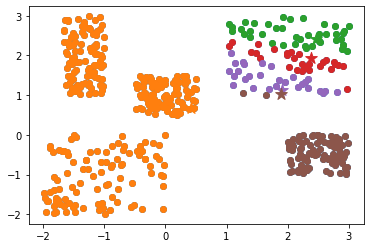

In [12]:
plt.scatter(data[ : , 0], data[ :, 1])
for i, c in enumerate(centroids):
  plot = plt.scatter(*c, marker='*', s=150)
  cluster = [datapoint for j, datapoint in enumerate(data) if cluster_assignments[j] == i]
  print(cluster)
  cluster = np.array(cluster)
  if len(cluster) == 0:
    continue
  plt.scatter(cluster[:, 0], cluster[:, 1], c=plot.get_facecolor())